# RL preliminaries

In [1]:

import gym, recogym
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import os
from datetime import datetime
import pandas as pd
import pickle as pkl
pd.options.mode.chained_assignment = None 
# from inspect import getsource
from recogym.evaluate_agent_sale import verify_agents_sale, display_metrics, verify_agents_sale_extended 
from tqdm import tqdm

# env_1_sale_args is a dictionary of default parameters (i.e. number of products)
from recogym import env_1_sale_args, Configuration
from recogym.agents.sale_agent import train_agents, train_timeagents
from recogym.envs.utils_sale import format_avg_result, avg_result, format_avg_result_extended, avg_result_extended


# You can overwrite environment arguments here:
env_1_sale_args['random_seed'] = 0
env_1_sale_args['num_products'] = 10
env_1_sale_args['number_of_flips'] = 10 

num_products = env_1_sale_args['num_products']
print('Number of products =',num_products)
print('Number of flips =',env_1_sale_args['number_of_flips'])
nb_flips = env_1_sale_args['number_of_flips']

# You can overwrite environment arguments here:
env_1_sale_args['random_seed'] = 42
env_1_sale_args['mu_sale'] = False 

# env_1_sale_args['kappa'] = 0.5
print('Value of kappa =',env_1_sale_args['kappa'])

# Initialize the gym 
env = gym.make('reco-gym-sale-v1')
env.init_gym(env_1_sale_args)



Number of products = 10
Number of flips = 10
Value of kappa = 0.2


In [2]:
# Repository to save pickles
data_repo = 'data_conversion/'

## Train baseline agents

#### Settings

In [3]:
## Choose number of users for training and AB test
# Number of users for the training
# env_1_sale_args['num_users'] = 6 ##tochange !!
env_1_sale_args['num_users'] = 5000
num_users = env_1_sale_args['num_users']

# Number of users for the A/B test
env_1_sale_args['num_users_AB'] = 7 ##tochange !!
# env_1_sale_args['num_users_AB'] = 5000
num_users_AB = env_1_sale_args['num_users_AB']

# Choose user features
from recogym.agents.sale_agent import CountViewsClicksFeatureProvider, CountViewsFeatureProvider, ShareViewsClicksFeatureProvider, ShareViewsFeatureProvider
vc_feature = CountViewsClicksFeatureProvider(env.config)
v_feature = CountViewsFeatureProvider(env.config)
vc_share_feature = ShareViewsClicksFeatureProvider(env.config)
v_share_feature = ShareViewsFeatureProvider(env.config)
features = {'vc':vc_feature,
           'v':v_feature,
           'vc_share':vc_share_feature,
           'v_share':v_share_feature}
feature_name = 'v_share'
feature = features[feature_name]

#### <font color='red'> Number of A/B tests</font>

In [4]:
# # Choose number of A/B tests
num_AB_tests = 2 ##tochange !
# num_AB_tests = 25 ##tochange !

#### Logs

In [5]:
agents={}
logs={}

############## Random agent
name_agent = 'rand'+str(nb_flips)
from recogym.agents import RandomAgent, random_args
random_agent = RandomAgent(Configuration(random_args))
agents[name_agent] = random_agent


try:
    logs[name_agent] = pkl.load(open(data_repo + 'data' + str(num_users) + name_agent + '.pkl','rb'))
    print('--- Logs loaded---')
except: 
    print("--- Generate logs ---")
    logs[name_agent] = deepcopy(env).generate_logs(num_users)
    print(data_repo + 'data' + str(num_users) + name_agent + '.pkl')
    pkl.dump(logs[name_agent], open(data_repo + 'data' + str(num_users) + name_agent + '.pkl','wb'))

--- Logs loaded---


In [6]:

from recogym.agents.sale_agent_repeated import PseudoRewards, ShareViewsCountClicksFeatureProvider
data = logs[name_agent]
RewardTilde = PseudoRewards(clicks_only=False)
RewardTilde.observe(data)
RewardTilde.pseudo_observe(RewardTilde.data_rewards)

In [7]:
RewardTilde.data_rewards["pseudo_y"]

6         0.0
7         0.0
8         0.0
9         0.0
10        0.0
         ... 
511604    0.0
511605    0.0
511606    0.0
511607    0.0
511608    0.0
Name: pseudo_y, Length: 392170, dtype: float64

In [8]:
UserFeatures = ShareViewsCountClicksFeatureProvider(config = env.config )
UserFeatures.reset()
# UserFeatures.observe(data)

In [9]:
# UserFeatures.features()
UserFeatures.features()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [10]:
env_1_sale_args

{'num_products': 10,
 'num_users': 5000,
 'random_seed': 42,
 'prob_leave_bandit': 0.01,
 'prob_leave_organic': 0.01,
 'prob_bandit_to_organic': 0.05,
 'prob_organic_to_bandit': 0.25,
 'normalize_beta': False,
 'with_ps_all': False,
 'num_clusters': 2,
 'phi_var': 0.1,
 'K': 5,
 'sigma_omega_initial': 1,
 'sigma_omega': 0.1,
 'number_of_flips': 10,
 'sigma_mu_organic': 3,
 'change_omega_for_bandits': False,
 'kappa': 0.2,
 'sigma_Lambda': 1,
 'psale_scale': 0.15,
 'delta_for_clicks': 0,
 'delta_for_views': 0,
 'sig_coef': 1,
 'mu_sale': False,
 'sigma_mu_sale': 0,
 'num_users_AB': 7}

## Question : how to initialize Q0 ? Train a discounted agent as a start to avoid long nb of iterations ? Better to start bad to check that it does in the right direction ?

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch import optim

import numpy as np

import gym
from gym.wrappers import Monitor
from pprint import pprint
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from IPython.display import clear_output

from pathlib import Path
import base64
import pandas as pd
import itertools
import seaborn as sns

### Simulator rewards, online

In [12]:
from recogym.agents.sale_agent_reinforce import Model, make_seed, REINFORCE

In [13]:
learning_rate = 0.015
gamma = 1.0  # every second counts the same
seed = 1235

config = {
    'learning_rate': 0.014,
    'seed': env_1_sale_args['random_seed'],
    'gamma': .98
}

print("Config : ",config)


Config :  {'learning_rate': 0.014, 'seed': 42, 'gamma': 0.98}


In [14]:
# agent = REINFORCE(config,env,UserFeatures)

# agent.train(n_trajectories=50, n_update=5)

# # Save the model
# datetag = datetime.now().strftime("%d%m%Y-%H%M%S")
# PATH = f"data/RL/reinforce_{datetag}.pth"
# print(PATH)
# torch.save(agent.model.state_dict(), PATH)
# # agent.model.state_dict = torch.load(PATH)
# agent.evaluate()

In [15]:
class PseudoREINFORCE(REINFORCE):
        
    def __init__(self, config, env, user_features, pseudo_reward_provider):
        super().__init__(config, env, user_features)
        self.pseudo_reward_provider = pseudo_reward_provider
    
    def _compute_pseudo_returns(self, rewards):
        num_rew = len(rewards)
        exponents = np.arange(num_rew)
        gammas = np.power(self.gamma, exponents)
        
        return rewards.dot(gammas)
    
        
    def optimize_model(self, n_trajectories):

        reward_trajectories = np.empty(n_trajectories)
        loss = 0.
        
        for i in range(n_trajectories):
            print('trajectory n°'+str(i))
            print(datetime.now())
            traj_rewards = []  # rewards of the trajectory
            traj_pseudo_rewards = []  # rewards of the trajectory
            traj_proba = 0.  # sum of log-probabilities of trajectory
            
            # Build trajectory
            done = False
            self.env.reset()
            # reset user features
            self.reset()
            obs_raw, _, done, reward = self.env.step(None)
            log = self.observation_to_log(obs_raw,reward)
            self.user_features.observe(log, memory=False)
            state = self.user_features.features()
            state = torch.from_numpy(state).float()
            while not done:
                action = self.model.select_action(state)  # can be cast to int for action idx
                # Get proba
                prob = self.model(state)[int(action)]
                traj_proba += torch.log(prob)
                
                obs_raw, reward, done, info = self.env.step(int(action))
                log = self.observation_to_log(obs_raw,reward)
                self.user_features.observe(log, memory=False)
                state = self.user_features.features()
                state = torch.from_numpy(state).float()

                self.pseudo_reward_provider.pseudo_observe(log)
                pseudo_reward = self.pseudo_reward_provider.data_rewards
                if reward > 0:
                    print("reward", reward)
                    print("pseudo rewards", pseudo_reward)
                # Store the new reward
                traj_rewards.append(reward)
                
                
            traj_rewards = np.array(traj_rewards)  # NumPy array
            
            # Get total reward
            total_reward = self._compute_returns(traj_rewards)  # NumPy array
            reward_trajectories[i] = total_reward
            
            loss = loss + total_reward * traj_proba / n_trajectories  # accumulate the negative criterion
            # reset user features construction and delete logs in memory
            self.reset()
            
        self.env.close()  # important
        
        loss = -loss
        
        # The following lines take care of the gradient descent step for the variable loss
        # that you need to compute.
        print("Loss:", loss.data.numpy())
        
        # Discard previous gradients
        self.optimizer.zero_grad()
        # Compute the gradient 
        loss.backward()
        # Do the gradient descent step
        self.optimizer.step()
        return reward_trajectories
    
    def train(self, n_trajectories, n_update):
        """Training method

        Parameters
        ----------
        n_trajectories : int
            The number of trajectories used to approximate the expected gradient
        n_update : int
            The number of gradient updates
            
        """
        
        final_update = self.current_ep + n_update
        rewards = self.rewards  # restart the reward record
        for episode in range(self.current_ep, final_update):
            rewards.append(self.optimize_model(n_trajectories))
            print(f'Episode {episode + 1}/{final_update}: rewards ' 
                  +f'{round(rewards[-1].mean(), 2)} +/- {round(rewards[-1].std(), 2)}')
            self.current_ep += 1
        
        # Plotting
        r = pd.DataFrame((itertools.chain(*(itertools.product([i], rewards[i]) for i in range(len(rewards))))), columns=['Epoch', 'Reward'])
        sns.lineplot(x="Epoch", y="Reward", data=r, ci='sd');
        
    

In [16]:
agent = PseudoREINFORCE(config,env,UserFeatures,RewardTilde)

trajectory n°0
2020-09-30 17:27:04.002220
trajectory n°1
2020-09-30 17:27:05.221006
trajectory n°2
2020-09-30 17:27:05.599771
Loss: -0.0
Episode 1/2: rewards 0.0 +/- 0.0
trajectory n°0
2020-09-30 17:27:07.460067
trajectory n°1
2020-09-30 17:27:29.560966
trajectory n°2
2020-09-30 17:27:33.391382
Loss: -0.0
Episode 2/2: rewards 0.0 +/- 0.0
data/RL/Pseudoreinforce_30092020-172802.pth


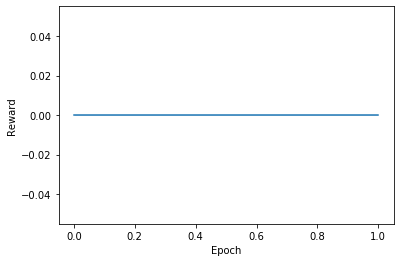

In [17]:
agent.train(n_trajectories=3, n_update=2)

# Save the model
datetag = datetime.now().strftime("%d%m%Y-%H%M%S")
PATH = f"data/RL/Pseudoreinforce_{datetag}.pth"
print(PATH)
torch.save(agent.model.state_dict(), PATH)
# agent.model.state_dict = torch.load(PATH)